In [15]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d

In [32]:
def find_topmost_true_green(img, a_thresh=-5):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    _, a, _ = cv2.split(lab)
    a_centered = a.astype(np.float32) - 128
    green_mask = (a_centered < a_thresh).astype(np.uint8)

    ys, xs = np.where(green_mask > 0)
    if len(ys) == 0:
        return None, None
    top_y = np.min(ys)
    top_x = xs[np.argmin(ys)]
    return top_x, top_y


def detect_grid_lines(img, smooth_sigma=2.5, bottom_range=(600, 720)):
    """
    Detects all horizontal grid lines from the image and selects the bottommost
    valid line constrained between the specified range (e.g., y ∈ [600, 720]).
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # --- Step 1: Local contrast enhancement ---
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray_eq = clahe.apply(gray)

    # --- Step 2: Adaptive threshold ---
    binary = cv2.adaptiveThreshold(
        gray_eq, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY_INV, 15, 8
    )

    # --- Step 3: Gentle dilation to strengthen faint grid lines ---
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    binary = cv2.dilate(binary, kernel, iterations=1)

    # --- Step 4: Extract horizontal components only ---
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 1))
    horizontal_lines = cv2.morphologyEx(binary, cv2.MORPH_OPEN, horizontal_kernel, iterations=1)

    # --- Step 5: Bottom emphasis weight (helps faint lines) ---
    h, w = horizontal_lines.shape
    weight_mask = np.linspace(1, 1.6, h).reshape(-1, 1)
    weighted = horizontal_lines.astype(np.float32) * weight_mask

    # --- Step 6: Row projection + smoothing ---
    row_sum = np.sum(weighted, axis=1)
    smooth = gaussian_filter1d(row_sum, sigma=smooth_sigma)
    smooth_norm = (smooth - np.min(smooth)) / (np.ptp(smooth) + 1e-6)

    # --- Step 7: Peak detection ---
    fft_mag = np.abs(np.fft.rfft(smooth_norm))
    main_freq_idx = np.argmax(fft_mag[2:]) + 2
    period_est = len(smooth_norm) / main_freq_idx
    est_distance = max(int(period_est * 0.6), 5)

    peaks, _ = find_peaks(
        smooth_norm,
        prominence=0.01,
        distance=est_distance
    )
    valid_peaks = np.sort([p for p in peaks if 0.02*h < p < 0.995*h])

    if len(valid_peaks) < 2:
        print("⚠️ Not enough grid lines detected.")
        return None, None, None, None, smooth_norm

    # --- Step 8: Compute unit distance (median spacing) ---
    spacings = np.diff(valid_peaks)
    avg_spacing = np.median(spacings)

    # --- Step 9: Select bottom-most peak within [600, 720] range ---
    constrained_peaks = [p for p in valid_peaks if bottom_range[0] <= p <= bottom_range[1]]
    if len(constrained_peaks) > 0:
        bottom_y = int(constrained_peaks[-1])
    else:
        # fallback: nearest below 750
        bottom_y = int(valid_peaks[-1]) if valid_peaks[-1] > 500 else None

    print(f"Detected {len(valid_peaks)} lines | avg spacing ≈ {avg_spacing:.2f}px | Bottom y={bottom_y}")
    return valid_peaks, bottom_y, None, avg_spacing, smooth_norm

def calculate_leaf_height(top_y, bottom_y, grid_peaks):
    if grid_peaks is None or len(grid_peaks) < 2:
        return None, None, None
    spacings = np.diff(np.sort(grid_peaks))
    unit_px = np.median(spacings)
    height_px = bottom_y - top_y
    height_units = height_px / unit_px
    return height_px, height_units, unit_px


In [33]:
def process_leaf_folder(input_folder, output_folder, results_csv):
    os.makedirs(output_folder, exist_ok=True)
    results = []

    for filename in os.listdir(input_folder):
        if not filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        image_path = os.path.join(input_folder, filename)
        img = cv2.imread(image_path)
        if img is None:
            print(f"⚠️ Could not read {filename}")
            continue

        top_x, top_y = find_topmost_true_green(img)
        grid_peaks, bottom_y, _, unit_px, smooth = detect_grid_lines(img)

        if top_y is None or bottom_y is None or grid_peaks is None:
            print(f"⚠️ Skipped {filename} — missing detections")
            continue

        height_px, height_units, unit_px = calculate_leaf_height(top_y, bottom_y, grid_peaks)
        if height_px is None or height_units is None:
            print(f"⚠️ Skipped {filename} — invalid height")
            continue

        # --- Draw overlay ---
        overlay = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape
        for y in grid_peaks:
            cv2.line(overlay, (0, y), (w, y), (0, 255, 0), 1)
        cv2.line(overlay, (0, bottom_y), (w, bottom_y), (0, 255, 255), 2)
        cv2.circle(overlay, (top_x, top_y), 10, (255, 0, 0), 2)

        cv2.putText(
            overlay,
            f"H = {height_units:.2f} units ({height_px:.1f}px)",
            (20, 40),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.8,
            (0, 128, 0),
            3,
            cv2.LINE_AA,
        )

        out_path = os.path.join(output_folder, f"marked_{filename}")
        cv2.imwrite(out_path, cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))

        results.append({
            "filename": filename,
            "top_y": top_y,
            "bottom_y": bottom_y,
            "unit_px": unit_px,
            "height_px": height_px,
            "height_units": height_units
        })

        print(f"✅ Processed {filename} | Height: {height_units:.2f} units")

    df = pd.DataFrame(results)
    df.to_csv(results_csv, index=False)
    print(f"\n📁 Results saved to: {results_csv}")
    print(f"🖼️ Annotated images saved to: {output_folder}")


In [34]:
input_folder = r"E:\Jain Irrigation\data\A\train_cropped"
output_folder = r"E:\Jain Irrigation\data\A\output_marked"
results_csv = os.path.join(output_folder, "leaf_heights.csv")

process_leaf_folder(input_folder, output_folder, results_csv)


Detected 25 lines | avg spacing ≈ 31.00px | Bottom y=717
✅ Processed IMG_20250920_110830496_HDR.jpg | Height: 8.74 units
Detected 25 lines | avg spacing ≈ 32.00px | Bottom y=711
✅ Processed IMG_20250920_110834031.jpg | Height: 7.59 units
Detected 22 lines | avg spacing ≈ 40.00px | Bottom y=715
✅ Processed IMG_20250920_110933781.jpg | Height: 9.30 units
Detected 20 lines | avg spacing ≈ 40.00px | Bottom y=699
✅ Processed IMG_20250920_110956857_HDR.jpg | Height: 9.32 units
Detected 27 lines | avg spacing ≈ 31.00px | Bottom y=716
✅ Processed IMG_20250920_111112931.jpg | Height: 7.35 units
Detected 22 lines | avg spacing ≈ 37.00px | Bottom y=697
✅ Processed IMG_20250920_111124376.jpg | Height: 9.03 units
Detected 20 lines | avg spacing ≈ 41.00px | Bottom y=680
✅ Processed IMG_20250920_111159428.jpg | Height: 8.27 units
Detected 18 lines | avg spacing ≈ 42.00px | Bottom y=719
✅ Processed IMG_20250920_111208760.jpg | Height: 10.26 units
Detected 19 lines | avg spacing ≈ 43.00px | Bottom y=70

Topmost green pixel: y=446
✅ Bottom line (grid): y=717
✅ Grid spacing: 31.00px
📏 Height = 271.0px ≈ 8.74 grid units


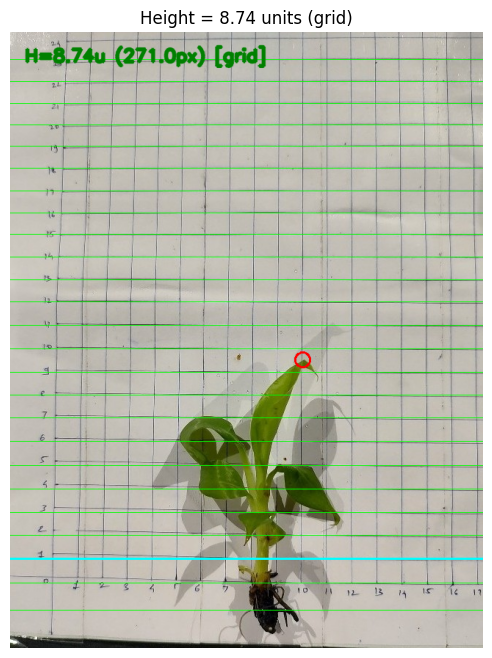

In [36]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d

# ---------------------- FUNCTIONS ---------------------- #

def find_topmost_true_green(img, a_thresh=-5):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    _, a, _ = cv2.split(lab)
    a_centered = a.astype(np.float32) - 128
    green_mask = (a_centered < a_thresh).astype(np.uint8)
    ys, xs = np.where(green_mask > 0)
    if len(ys) == 0:
        return None, None
    top_y = np.min(ys)
    top_x = xs[np.argmin(ys)]
    return top_x, top_y


def detect_bottom_blue_line(img, show=False):
    """Detect the lowest dark-blue horizontal line (ball pen)."""
    b, g, r = cv2.split(img)
    blueness = b.astype(np.float32) - np.maximum(r, g).astype(np.float32)
    blue_mask = (blueness > 30).astype(np.uint8) * 255

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 3))
    blue_lines = cv2.morphologyEx(blue_mask, cv2.MORPH_OPEN, kernel)

    row_sum = np.sum(blue_lines, axis=1)
    smooth = gaussian_filter1d(row_sum, sigma=4)
    peaks, _ = find_peaks(smooth, height=0.3*np.max(smooth), distance=10)

    if len(peaks) == 0:
        return None, blue_lines

    bottom_y = int(np.max(peaks))

    if show:
        plt.figure(figsize=(10, 4))
        plt.plot(smooth, color='blue')
        plt.scatter(peaks, smooth[peaks], color='red')
        plt.axvline(bottom_y, color='lime', lw=2, label=f"Bottom y={bottom_y}")
        plt.legend()
        plt.title("Blue Line Detection")
        plt.show()

        overlay = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
        cv2.line(overlay, (0, bottom_y), (overlay.shape[1], bottom_y), (0, 255, 0), 2)
        plt.imshow(overlay)
        plt.title(f"Detected Bottom Blue Line (y={bottom_y})")
        plt.axis("off")
        plt.show()

    return bottom_y, blue_lines


def detect_grid_lines(img, smooth_sigma=2.5, bottom_range=(600, 720)):
    """Detect grid lines and compute periodic spacing."""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray_eq = clahe.apply(gray)

    binary = cv2.adaptiveThreshold(
        gray_eq, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY_INV, 15, 8
    )

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    binary = cv2.dilate(binary, kernel, iterations=1)

    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 1))
    horizontal_lines = cv2.morphologyEx(binary, cv2.MORPH_OPEN, horizontal_kernel, iterations=1)

    h, w = horizontal_lines.shape
    weight_mask = np.linspace(1, 1.6, h).reshape(-1, 1)
    weighted = horizontal_lines.astype(np.float32) * weight_mask

    row_sum = np.sum(weighted, axis=1)
    smooth = gaussian_filter1d(row_sum, sigma=smooth_sigma)
    smooth_norm = (smooth - np.min(smooth)) / (np.ptp(smooth) + 1e-6)

    fft_mag = np.abs(np.fft.rfft(smooth_norm))
    main_freq_idx = np.argmax(fft_mag[2:]) + 2
    period_est = len(smooth_norm) / main_freq_idx
    est_distance = max(int(period_est * 0.6), 5)

    peaks, _ = find_peaks(
        smooth_norm,
        prominence=0.01,
        distance=est_distance
    )
    valid_peaks = np.sort([p for p in peaks if 0.02*h < p < 0.995*h])

    if len(valid_peaks) < 2:
        return None, None, None, None, smooth_norm

    spacings = np.diff(valid_peaks)
    avg_spacing = np.median(spacings)

    constrained_peaks = [p for p in valid_peaks if bottom_range[0] <= p <= bottom_range[1]]
    if len(constrained_peaks) > 0:
        bottom_y = int(constrained_peaks[-1])
    else:
        bottom_y = int(valid_peaks[-1]) if valid_peaks[-1] > 500 else None

    return valid_peaks, bottom_y, None, avg_spacing, smooth_norm


def calculate_leaf_height(top_y, bottom_y, grid_peaks):
    if len(grid_peaks) < 2 or top_y is None or bottom_y is None:
        return None, None, None
    spacings = np.diff(np.sort(grid_peaks))
    unit_px = np.median(spacings)
    height_px = bottom_y - top_y
    height_units = height_px / unit_px
    return height_px, height_units, unit_px


# ---------------------- RUN ON ONE IMAGE ---------------------- #

image_path = r"E:\Jain Irrigation\data\A\train_cropped\IMG_20250920_110830496_HDR.jpg"

img = cv2.imread(image_path)
if img is None:
    raise ValueError(f"❌ Could not read {image_path}")

h, w, _ = img.shape

# Step 1: detect top green
top_x, top_y = find_topmost_true_green(img)
print(f"Topmost green pixel: y={top_y}")

# Step 2: detect bottom blue
bottom_y_blue, blue_mask = detect_bottom_blue_line(img, show=True)

# Step 3: detect grid for spacing
grid_peaks, bottom_y_grid, _, _, smooth = detect_grid_lines(img)

# Step 4: choose bottom_y
if bottom_y_blue is not None:
    bottom_y = bottom_y_blue
    method_used = "blue"
else:
    bottom_y = bottom_y_grid
    method_used = "grid"

if any(x is None for x in [top_y, bottom_y, grid_peaks]):
    print("⚠️ Missing detections; skipping visualization.")
else:
    height_px, height_units, unit_px = calculate_leaf_height(top_y, bottom_y, grid_peaks)
    print(f"✅ Bottom line ({method_used}): y={bottom_y}")
    print(f"✅ Grid spacing: {unit_px:.2f}px")
    print(f"📏 Height = {height_px:.1f}px ≈ {height_units:.2f} grid units")

    # Visualization
    overlay = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
    for y in grid_peaks:
        cv2.line(overlay, (0, y), (w, y), (0, 255, 0), 1)
    cv2.line(overlay, (0, bottom_y), (w, bottom_y), (0, 255, 255), 2)
    cv2.circle(overlay, (top_x, top_y), 10, (255, 0, 0), 2)
    cv2.putText(overlay, f"H={height_units:.2f}u ({height_px:.1f}px) [{method_used}]",
                (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 128, 0), 3, cv2.LINE_AA)

    plt.figure(figsize=(8, 8))
    plt.imshow(overlay)
    plt.title(f"Height = {height_units:.2f} units ({method_used})")
    plt.axis("off")
    plt.show()
